In [1]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import RandomTranslation, GaussianNoise, Normalization, BatchNormalization, ReLU
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, Conv2D

from final_project.smlm_3d.workflow_v2 import eval_model

SEED = 42
class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
#         self.gaussian_noise = GaussianNoise(0.1, seed=SEED)
        self.transpose = RandomTranslation(0.1, 0.1)
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512)
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512)
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(1)

    def call(self, inp, training):
        x, coords = inp
        # data augmentation steps
#         x = self.gaussian_noise(x, training=training)
        x = self.transpose(x, training=training)
        
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)

        # Concat norm X/Y coordinates
        x = tf.concat((x, coords), axis=1)

        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        # Restrict to valid output range [-1000, 1000]    
#         x = tf.tanh(x) * 1000
        return x

    def test_step(self, data):
        (img, coords), y = data
        y_pred = self((img, coords), training=False)

        shifted_pred = shift_correction(y, y_pred)

        self.compiled_loss(y, shifted_pred, regularization_losses=self.losses)
        self.compiled_metrics.update_state(y, shifted_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}



def load_regression_model():

    # model = Sequential()
    # model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Dropout(0.25))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(1, activation='linear'))

    model = ResNet34()
    
#     model = res34()
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=0.01, decay=1e-6),metrics=['mean_absolute_error'])
    return model

model = load_regression_model()


In [2]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
def train_model(dataset, val_dataset=None):
    if not val_dataset:
        val_dataset = dataset['val']
    for k in dataset:
        imgs = dataset[k][0][0]
        norm_imgs = imgs / imgs.max(axis=(1, 2))[:, np.newaxis, np.newaxis]
        dataset[k][0][0] = norm_imgs

    model = load_regression_model()

    callbacks = [
        ReduceLROnPlateau(
        monitor='loss', factor=0.1, patience=20, verbose=True,
        mode='min', min_delta=1, cooldown=0, min_lr=1e-10,),
        EarlyStopping(monitor='val_mean_absolute_error', patience=100, verbose=True, min_delta=1, restore_best_weights=True),
    ]

#     print(dataset['train'][0][0].shape)
#     print(dataset['train'][0][1].shape)
#     print(dataset['train'][1].shape)

    history = model.fit(*dataset['train'], epochs=500, batch_size=8196*2, validation_data=(*val_dataset,), callbacks=callbacks, verbose=True)

    fig, ax1 = plt.subplots()
    ax1.plot(history.history['mean_absolute_error'], label='mse')
    ax1.plot(history.history['val_mean_absolute_error'], label='val_mse')
    ax1.set_yscale('log')
    ax1.legend(loc=1)
    ax2 = ax1.twinx()
    ax2.plot(history.history['lr'], label='lr')
    ax2.legend(loc=0)

    plt.show()
    return model


In [3]:
from scipy.optimize import curve_fit

def shift_correction(y, y_pred):
    y_pred = y_pred -  tf.math.reduce_mean(y_pred) +  tf.math.reduce_mean(y)
    return y_pred

In [4]:
def test_model(model, train_dataset):
    test_x, test_y = train_dataset.data['test']
    pred_y = model.predict(test_x).squeeze()
    error = abs(test_y-pred_y)
    print(f'Mean error {np.mean(error)}')
    print(f'std error {np.std(error)}')
    return error


10
Reading img...
Loading /home/miguel/Projects/uni/data/smlm_3d/20211006_100nm_beads_Miguel/Original_FOV_647nm_300ms_2binning/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1_MMStack_Default.ome.tif
Loading /home/miguel/Projects/uni/data/smlm_3d/20211006_100nm_beads_Miguel/Original_FOV_647nm_300ms_2binning/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1/100nm_Tetraspeck_beads_zstack_4um_10nm_647nm_300ms_1_MMStack_Default.csv
10 [10, 90, 90]
(401, 1080, 1280)
(401, 1080, 1280)

using image sharpness
724 emitters before filtering
322 emitters after proximity filtering.
305 emitters after borders


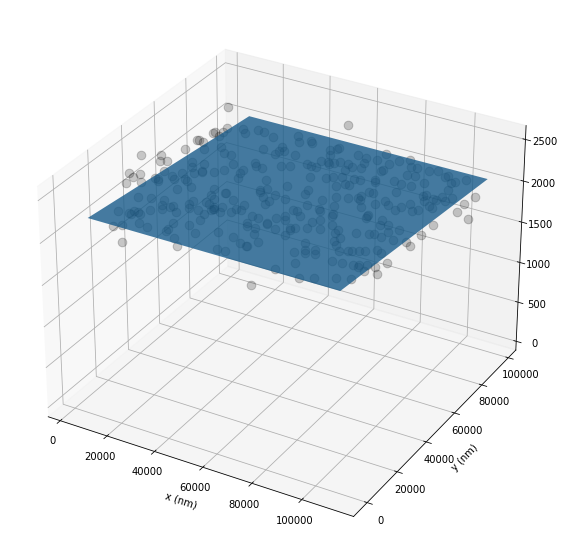

/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


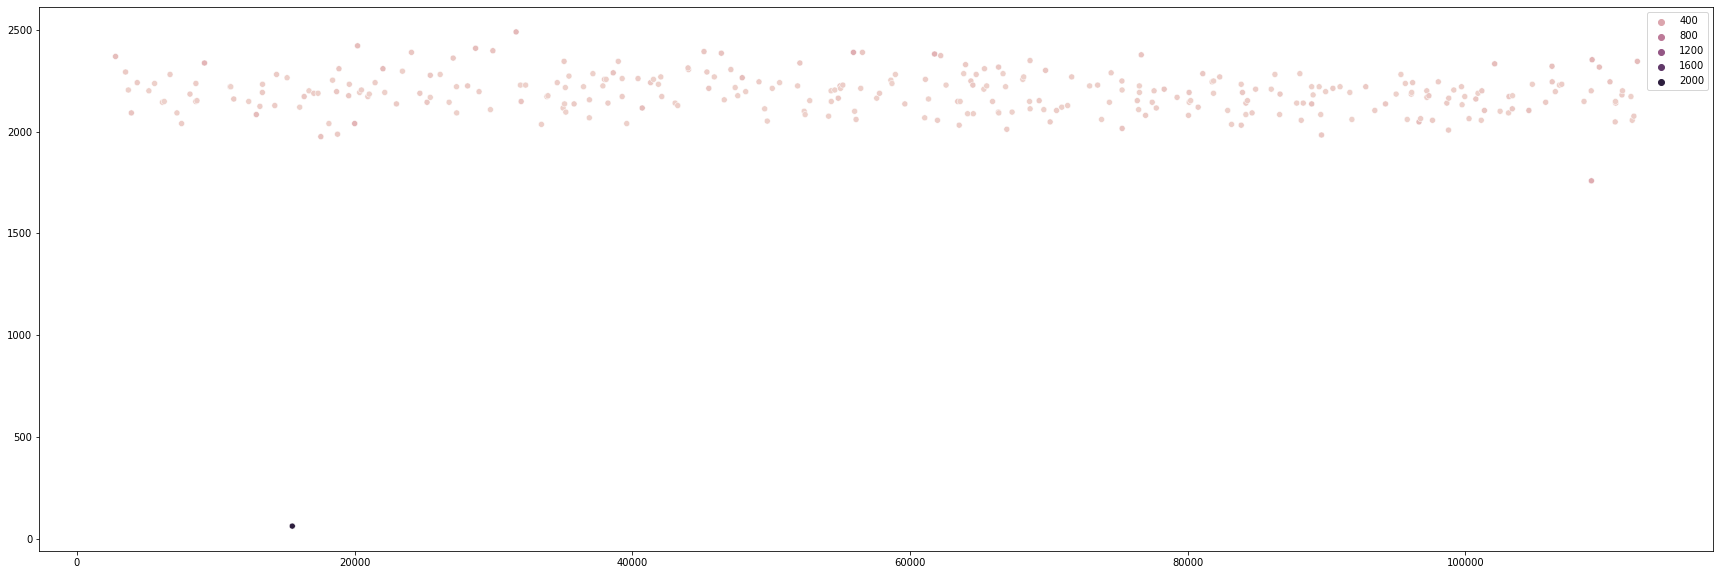

/home/miguel/Projects/uni/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


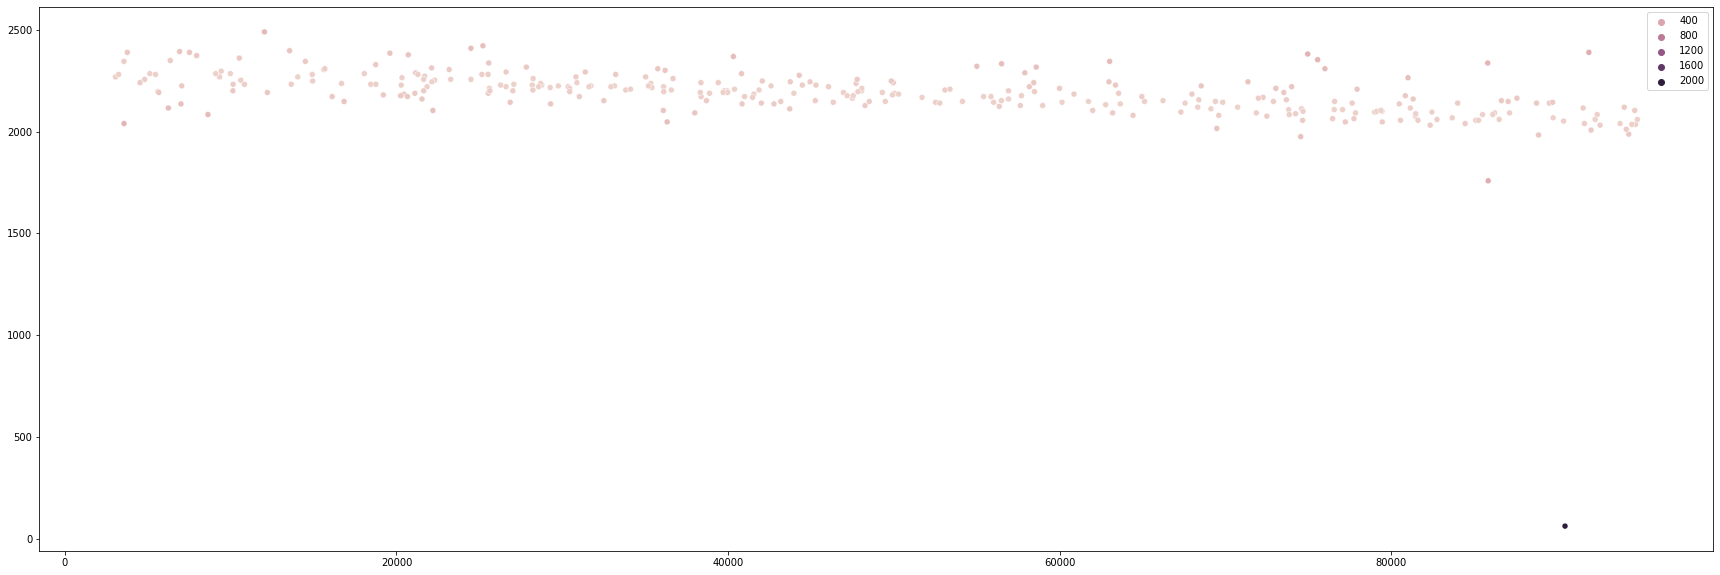

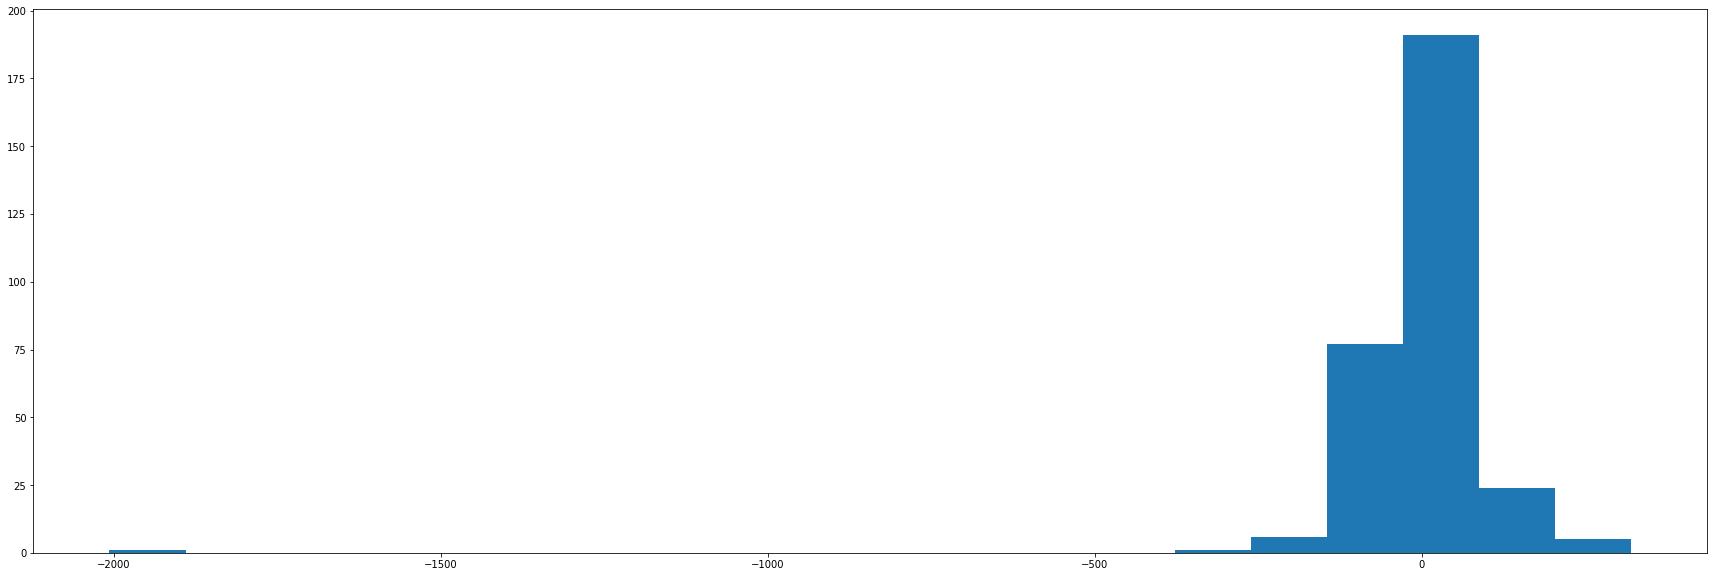

Adding noise
Epoch 1/500
29/29 [==============================] - 31s 722ms/step - loss: 263081.2812 - mean_absolute_error: 397.9830 - val_loss: 6174141652664320.0000 - val_mean_absolute_error: 59274300.0000 - lr: 0.0100
Epoch 2/500
29/29 [==============================] - 16s 536ms/step - loss: 53989.6484 - mean_absolute_error: 166.5803 - val_loss: 47689625600.0000 - val_mean_absolute_error: 167019.4219 - lr: 0.0100
Epoch 3/500
29/29 [==============================] - 16s 538ms/step - loss: 15994.5527 - mean_absolute_error: 88.1199 - val_loss: 43768340.0000 - val_mean_absolute_error: 4982.6714 - lr: 0.0100
Epoch 4/500
29/29 [==============================] - 16s 539ms/step - loss: 12429.2607 - mean_absolute_error: 77.9256 - val_loss: 1302124.2500 - val_mean_absolute_error: 905.1791 - lr: 0.0100
Epoch 5/500
29/29 [==============================] - 16s 540ms/step - loss: 10171.9287 - mean_absolute_error: 71.3837 - val_loss: 286266.7188 - val_mean_absolute_error: 462.2496 - lr: 0.0100
Ep

29/29 [==============================] - 16s 541ms/step - loss: 5189.3779 - mean_absolute_error: 52.9426 - val_loss: 3506.2302 - val_mean_absolute_error: 34.0274 - lr: 0.0100
Epoch 45/500
29/29 [==============================] - 16s 540ms/step - loss: 5462.9321 - mean_absolute_error: 54.1374 - val_loss: 10775.9541 - val_mean_absolute_error: 80.2463 - lr: 0.0100
Epoch 46/500
29/29 [==============================] - 16s 540ms/step - loss: 5175.2881 - mean_absolute_error: 52.9686 - val_loss: 4311.9058 - val_mean_absolute_error: 45.3504 - lr: 0.0100
Epoch 47/500
29/29 [==============================] - 16s 541ms/step - loss: 5051.6812 - mean_absolute_error: 52.4248 - val_loss: 2238.3953 - val_mean_absolute_error: 29.8334 - lr: 0.0100
Epoch 48/500
29/29 [==============================] - 16s 540ms/step - loss: 5125.5449 - mean_absolute_error: 52.8215 - val_loss: 6315.9365 - val_mean_absolute_error: 59.0510 - lr: 0.0100
Epoch 49/500
29/29 [==============================] - 16s 540ms/step - l

29/29 [==============================] - 16s 540ms/step - loss: 4851.2393 - mean_absolute_error: 51.8041 - val_loss: 7858.7373 - val_mean_absolute_error: 65.1329 - lr: 0.0100
Epoch 88/500
29/29 [==============================] - 16s 540ms/step - loss: 4704.7407 - mean_absolute_error: 51.5163 - val_loss: 9414.3311 - val_mean_absolute_error: 76.6299 - lr: 0.0100
Epoch 89/500
29/29 [==============================] - 16s 542ms/step - loss: 6100.4717 - mean_absolute_error: 59.9878 - val_loss: 8366.3193 - val_mean_absolute_error: 67.0681 - lr: 0.0100
Epoch 90/500
29/29 [==============================] - 16s 541ms/step - loss: 4794.2031 - mean_absolute_error: 51.6372 - val_loss: 5154.0371 - val_mean_absolute_error: 49.8643 - lr: 0.0100
Epoch 91/500
29/29 [==============================] - 16s 541ms/step - loss: 4720.2808 - mean_absolute_error: 51.1726 - val_loss: 3999.4763 - val_mean_absolute_error: 42.8389 - lr: 0.0100
Epoch 92/500
29/29 [==============================] - 16s 541ms/step - lo

29/29 [==============================] - 16s 540ms/step - loss: 4505.2065 - mean_absolute_error: 50.6530 - val_loss: 5363.3237 - val_mean_absolute_error: 52.4681 - lr: 0.0100
Epoch 131/500
29/29 [==============================] - 16s 542ms/step - loss: 4816.5552 - mean_absolute_error: 52.1666 - val_loss: 1480.2334 - val_mean_absolute_error: 26.3163 - lr: 0.0100
Epoch 132/500
29/29 [==============================] - 16s 540ms/step - loss: 4377.6255 - mean_absolute_error: 49.4986 - val_loss: 3679.9502 - val_mean_absolute_error: 44.8881 - lr: 0.0100
Epoch 133/500
29/29 [==============================] - 16s 540ms/step - loss: 4375.7324 - mean_absolute_error: 49.6666 - val_loss: 1807.8331 - val_mean_absolute_error: 30.4246 - lr: 0.0100
Epoch 134/500
29/29 [==============================] - 16s 540ms/step - loss: 4502.6489 - mean_absolute_error: 50.2567 - val_loss: 1361.0870 - val_mean_absolute_error: 27.1222 - lr: 0.0100
Epoch 135/500
29/29 [==============================] - 16s 540ms/step

Epoch 172/500
29/29 [==============================] - 16s 540ms/step - loss: 3783.5063 - mean_absolute_error: 45.9961 - val_loss: 971.0273 - val_mean_absolute_error: 21.3411 - lr: 1.0000e-03
Epoch 173/500
29/29 [==============================] - 16s 540ms/step - loss: 3803.9165 - mean_absolute_error: 46.1528 - val_loss: 1101.6112 - val_mean_absolute_error: 22.0112 - lr: 1.0000e-03
Epoch 174/500
29/29 [==============================] - 16s 540ms/step - loss: 3788.1189 - mean_absolute_error: 46.0574 - val_loss: 1229.4904 - val_mean_absolute_error: 23.5930 - lr: 1.0000e-03
Epoch 175/500
29/29 [==============================] - 16s 540ms/step - loss: 3782.0454 - mean_absolute_error: 46.0087 - val_loss: 1252.8290 - val_mean_absolute_error: 22.9861 - lr: 1.0000e-03
Epoch 176/500
29/29 [==============================] - 16s 540ms/step - loss: 3788.1252 - mean_absolute_error: 46.1102 - val_loss: 1052.4706 - val_mean_absolute_error: 21.6199 - lr: 1.0000e-03
Epoch 177/500
29/29 [===============

29/29 [==============================] - 16s 541ms/step - loss: 3731.8347 - mean_absolute_error: 45.7449 - val_loss: 1441.5851 - val_mean_absolute_error: 26.0117 - lr: 1.0000e-03
Epoch 223/500
29/29 [==============================] - 16s 541ms/step - loss: 3773.5952 - mean_absolute_error: 45.9744 - val_loss: 1581.9974 - val_mean_absolute_error: 25.4992 - lr: 1.0000e-03
Epoch 224/500
29/29 [==============================] - 16s 541ms/step - loss: 3762.8723 - mean_absolute_error: 45.8713 - val_loss: 1584.1735 - val_mean_absolute_error: 28.5400 - lr: 1.0000e-03
Epoch 225/500
29/29 [==============================] - 16s 541ms/step - loss: 3724.0042 - mean_absolute_error: 45.7233 - val_loss: 1493.9714 - val_mean_absolute_error: 29.6864 - lr: 1.0000e-03
Epoch 226/500
29/29 [==============================] - 16s 541ms/step - loss: 3763.5293 - mean_absolute_error: 45.8787 - val_loss: 1566.3817 - val_mean_absolute_error: 28.6902 - lr: 1.0000e-03
Epoch 227/500
29/29 [============================

29/29 [==============================] - 16s 540ms/step - loss: 3686.8286 - mean_absolute_error: 45.4685 - val_loss: 1615.8351 - val_mean_absolute_error: 30.2076 - lr: 1.0000e-03
Epoch 265/500
29/29 [==============================] - 16s 540ms/step - loss: 3706.9917 - mean_absolute_error: 45.6272 - val_loss: 1447.7083 - val_mean_absolute_error: 25.3293 - lr: 1.0000e-03
Epoch 266/500
29/29 [==============================] - 16s 540ms/step - loss: 3675.6826 - mean_absolute_error: 45.4700 - val_loss: 1001.6971 - val_mean_absolute_error: 22.9003 - lr: 1.0000e-03
Epoch 267/500
29/29 [==============================] - 16s 540ms/step - loss: 3685.3647 - mean_absolute_error: 45.5136 - val_loss: 1148.6300 - val_mean_absolute_error: 25.0192 - lr: 1.0000e-03
Epoch 268/500
29/29 [==============================] - 16s 541ms/step - loss: 3728.2300 - mean_absolute_error: 45.7019 - val_loss: 1383.5574 - val_mean_absolute_error: 28.2857 - lr: 1.0000e-03
Epoch 269/500
29/29 [============================

29/29 [==============================] - 16s 540ms/step - loss: 3645.7368 - mean_absolute_error: 45.3462 - val_loss: 1099.3025 - val_mean_absolute_error: 23.6687 - lr: 1.0000e-03
Epoch 307/500
29/29 [==============================] - 16s 540ms/step - loss: 3643.5137 - mean_absolute_error: 45.2879 - val_loss: 1449.3838 - val_mean_absolute_error: 27.9860 - lr: 1.0000e-03
Epoch 308/500
29/29 [==============================] - 16s 540ms/step - loss: 3635.3579 - mean_absolute_error: 45.2583 - val_loss: 1119.6426 - val_mean_absolute_error: 23.9362 - lr: 1.0000e-03
Epoch 309/500
29/29 [==============================] - 16s 540ms/step - loss: 3643.3369 - mean_absolute_error: 45.2897 - val_loss: 1133.1525 - val_mean_absolute_error: 23.1578 - lr: 1.0000e-03
Epoch 310/500
29/29 [==============================] - 16s 541ms/step - loss: 3626.1045 - mean_absolute_error: 45.2255 - val_loss: 1179.9460 - val_mean_absolute_error: 23.8127 - lr: 1.0000e-03
Epoch 311/500
29/29 [============================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



5/5 [==============================] - 3s 521ms/step - loss: 121317.8281 - mean_absolute_error: 251.0432 - val_loss: 1780668839348928512.0000 - val_mean_absolute_error: 1004154496.0000 - lr: 0.0100
Epoch 7/500
5/5 [==============================] - 3s 529ms/step - loss: 144931.0312 - mean_absolute_error: 281.8257 - val_loss: 6137019176583168.0000 - val_mean_absolute_error: 58113220.0000 - lr: 0.0100
Epoch 8/500
5/5 [==============================] - 3s 529ms/step - loss: 88161.3906 - mean_absolute_error: 215.2470 - val_loss: 31780423860224.0000 - val_mean_absolute_error: 4155274.5000 - lr: 0.0100
Epoch 9/500
5/5 [==============================] - 3s 530ms/step - loss: 53969.2617 - mean_absolute_error: 161.1342 - val_loss: 575978405888.0000 - val_mean_absolute_error: 554275.3125 - lr: 0.0100
Epoch 10/500
5/5 [==============================] - 3s 530ms/step - loss: 40535.4805 - mean_absolute_error: 136.8933 - val_loss: 19902746624.0000 - val_mean_absolute_error: 96525.7969 - lr: 0.0100
E

Epoch 49/500
5/5 [==============================] - 3s 522ms/step - loss: 7319.2139 - mean_absolute_error: 62.9409 - val_loss: 331177.0938 - val_mean_absolute_error: 506.4282 - lr: 0.0100
Epoch 50/500
5/5 [==============================] - 3s 522ms/step - loss: 7569.8550 - mean_absolute_error: 64.3786 - val_loss: 366896.8125 - val_mean_absolute_error: 531.2965 - lr: 0.0100
Epoch 51/500
5/5 [==============================] - 3s 522ms/step - loss: 7570.3750 - mean_absolute_error: 64.6068 - val_loss: 336724.9062 - val_mean_absolute_error: 511.2775 - lr: 0.0100
Epoch 52/500
5/5 [==============================] - 3s 530ms/step - loss: 7305.4727 - mean_absolute_error: 63.2364 - val_loss: 335105.4375 - val_mean_absolute_error: 500.9648 - lr: 0.0100
Epoch 53/500
5/5 [==============================] - 3s 530ms/step - loss: 7303.5249 - mean_absolute_error: 62.0487 - val_loss: 313524.1562 - val_mean_absolute_error: 473.9431 - lr: 0.0100
Epoch 54/500
5/5 [==============================] - 3s 521ms

Epoch 93/500
5/5 [==============================] - 3s 521ms/step - loss: 5710.6460 - mean_absolute_error: 56.0769 - val_loss: 11681.3428 - val_mean_absolute_error: 63.4186 - lr: 0.0100
Epoch 94/500
5/5 [==============================] - 3s 530ms/step - loss: 5752.8623 - mean_absolute_error: 56.0761 - val_loss: 6792.5825 - val_mean_absolute_error: 47.4298 - lr: 0.0100
Epoch 95/500
5/5 [==============================] - 3s 521ms/step - loss: 5659.1855 - mean_absolute_error: 55.7930 - val_loss: 7398.1826 - val_mean_absolute_error: 53.8117 - lr: 0.0100
Epoch 96/500
5/5 [==============================] - 3s 521ms/step - loss: 5659.1372 - mean_absolute_error: 56.0381 - val_loss: 7270.8887 - val_mean_absolute_error: 50.8227 - lr: 0.0100
Epoch 97/500
5/5 [==============================] - 3s 522ms/step - loss: 5665.5425 - mean_absolute_error: 56.1038 - val_loss: 7565.3516 - val_mean_absolute_error: 53.6811 - lr: 0.0100
Epoch 98/500
5/5 [==============================] - 3s 521ms/step - loss: 

Epoch 136/500
5/5 [==============================] - 3s 521ms/step - loss: 5003.5137 - mean_absolute_error: 52.7821 - val_loss: 6214.2095 - val_mean_absolute_error: 39.5791 - lr: 1.0000e-03
Epoch 137/500
5/5 [==============================] - 3s 522ms/step - loss: 4935.6792 - mean_absolute_error: 52.4347 - val_loss: 6435.8613 - val_mean_absolute_error: 39.9619 - lr: 1.0000e-03
Epoch 138/500
5/5 [==============================] - 3s 522ms/step - loss: 4981.3071 - mean_absolute_error: 52.7966 - val_loss: 6251.5542 - val_mean_absolute_error: 39.3187 - lr: 1.0000e-03
Epoch 139/500
5/5 [==============================] - 3s 521ms/step - loss: 4886.4229 - mean_absolute_error: 52.2474 - val_loss: 6536.1616 - val_mean_absolute_error: 41.1364 - lr: 1.0000e-03
Epoch 140/500
5/5 [==============================] - 3s 521ms/step - loss: 4890.4995 - mean_absolute_error: 52.3878 - val_loss: 6272.4771 - val_mean_absolute_error: 39.1470 - lr: 1.0000e-03
Epoch 141/500
5/5 [==============================]

5/5 [==============================] - 3s 522ms/step - loss: 4874.6904 - mean_absolute_error: 52.2092 - val_loss: 4745.6987 - val_mean_absolute_error: 36.2970 - lr: 1.0000e-03
Epoch 180/500
5/5 [==============================] - 3s 522ms/step - loss: 4837.8018 - mean_absolute_error: 51.9140 - val_loss: 4671.9512 - val_mean_absolute_error: 35.8801 - lr: 1.0000e-03
Epoch 181/500
5/5 [==============================] - 3s 522ms/step - loss: 4914.8091 - mean_absolute_error: 52.2953 - val_loss: 4296.7393 - val_mean_absolute_error: 35.4402 - lr: 1.0000e-03
Epoch 182/500
5/5 [==============================] - 3s 522ms/step - loss: 4854.3140 - mean_absolute_error: 52.2006 - val_loss: 4319.3560 - val_mean_absolute_error: 35.5133 - lr: 1.0000e-03
Epoch 183/500
5/5 [==============================] - 3s 522ms/step - loss: 4808.7339 - mean_absolute_error: 51.8184 - val_loss: 4420.2388 - val_mean_absolute_error: 35.8654 - lr: 1.0000e-03
Epoch 184/500
5/5 [==============================] - 3s 523ms/st

5/5 [==============================] - 3s 521ms/step - loss: 4759.8936 - mean_absolute_error: 51.5945 - val_loss: 5445.1768 - val_mean_absolute_error: 41.9101 - lr: 1.0000e-03
Epoch 223/500
5/5 [==============================] - 3s 521ms/step - loss: 4804.2021 - mean_absolute_error: 51.7349 - val_loss: 5261.2168 - val_mean_absolute_error: 43.7433 - lr: 1.0000e-03
Epoch 224/500
5/5 [==============================] - 3s 522ms/step - loss: 4823.8589 - mean_absolute_error: 52.0572 - val_loss: 5970.3794 - val_mean_absolute_error: 46.3633 - lr: 1.0000e-03
Epoch 225/500
5/5 [==============================] - 3s 521ms/step - loss: 4774.7153 - mean_absolute_error: 51.8764 - val_loss: 5799.7363 - val_mean_absolute_error: 43.2806 - lr: 1.0000e-03
Epoch 226/500
5/5 [==============================] - 3s 522ms/step - loss: 4791.3921 - mean_absolute_error: 51.5652 - val_loss: 5394.4307 - val_mean_absolute_error: 39.6566 - lr: 1.0000e-03
Epoch 227/500
5/5 [==============================] - 3s 522ms/st

5/5 [==============================] - 3s 522ms/step - loss: 4752.6157 - mean_absolute_error: 51.6314 - val_loss: 5029.9473 - val_mean_absolute_error: 32.5716 - lr: 1.0000e-03
Epoch 266/500
5/5 [==============================] - 3s 523ms/step - loss: 4734.1011 - mean_absolute_error: 51.5825 - val_loss: 4631.6016 - val_mean_absolute_error: 31.8365 - lr: 1.0000e-03
Epoch 267/500
5/5 [==============================] - 3s 523ms/step - loss: 4694.2812 - mean_absolute_error: 51.4493 - val_loss: 4689.2319 - val_mean_absolute_error: 33.4744 - lr: 1.0000e-03
Epoch 268/500
5/5 [==============================] - 3s 523ms/step - loss: 4718.8052 - mean_absolute_error: 51.3175 - val_loss: 4735.1807 - val_mean_absolute_error: 35.0916 - lr: 1.0000e-03
Epoch 269/500
5/5 [==============================] - 3s 523ms/step - loss: 4708.6265 - mean_absolute_error: 51.4575 - val_loss: 4334.1621 - val_mean_absolute_error: 35.4515 - lr: 1.0000e-03
Epoch 270/500
5/5 [==============================] - 3s 522ms/st

5/5 [==============================] - 3s 522ms/step - loss: 4689.2661 - mean_absolute_error: 51.2075 - val_loss: 4735.3877 - val_mean_absolute_error: 38.8304 - lr: 1.0000e-03
Epoch 309/500
5/5 [==============================] - 3s 522ms/step - loss: 4642.2168 - mean_absolute_error: 51.0983 - val_loss: 4995.0303 - val_mean_absolute_error: 40.3160 - lr: 1.0000e-03
Epoch 310/500
5/5 [==============================] - 3s 522ms/step - loss: 4682.7212 - mean_absolute_error: 51.2090 - val_loss: 4814.1948 - val_mean_absolute_error: 40.1049 - lr: 1.0000e-03
Epoch 311/500
5/5 [==============================] - 3s 522ms/step - loss: 4603.5806 - mean_absolute_error: 50.8266 - val_loss: 5091.1719 - val_mean_absolute_error: 33.5970 - lr: 1.0000e-03
Epoch 312/500
5/5 [==============================] - 3s 522ms/step - loss: 4644.4604 - mean_absolute_error: 50.9785 - val_loss: 5557.4023 - val_mean_absolute_error: 36.8191 - lr: 1.0000e-03
Epoch 313/500
5/5 [==============================] - 3s 522ms/st

5/5 [==============================] - 3s 522ms/step - loss: 4673.8159 - mean_absolute_error: 51.1620 - val_loss: 4873.2300 - val_mean_absolute_error: 31.4145 - lr: 1.0000e-03
Epoch 352/500
5/5 [==============================] - 3s 522ms/step - loss: 4639.8374 - mean_absolute_error: 50.8634 - val_loss: 4720.5068 - val_mean_absolute_error: 32.3378 - lr: 1.0000e-03
Epoch 353/500
5/5 [==============================] - 3s 522ms/step - loss: 4609.2349 - mean_absolute_error: 50.8591 - val_loss: 3851.1987 - val_mean_absolute_error: 30.2616 - lr: 1.0000e-03
Epoch 354/500
5/5 [==============================] - 3s 523ms/step - loss: 4595.7773 - mean_absolute_error: 50.7964 - val_loss: 4195.0737 - val_mean_absolute_error: 35.7311 - lr: 1.0000e-03
Epoch 355/500
5/5 [==============================] - ETA: 0s - loss: 4604.4019 - mean_absolute_error: 50.9988
Epoch 00355: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
5/5 [==============================] - 3s 523ms/step - loss: 460

5/5 [==============================] - 3s 522ms/step - loss: 4568.0962 - mean_absolute_error: 50.4245 - val_loss: 5008.3008 - val_mean_absolute_error: 34.9007 - lr: 1.0000e-04
Epoch 394/500
5/5 [==============================] - 3s 522ms/step - loss: 4525.1738 - mean_absolute_error: 50.4509 - val_loss: 4750.1870 - val_mean_absolute_error: 34.4671 - lr: 1.0000e-04
Epoch 395/500
5/5 [==============================] - 3s 523ms/step - loss: 4526.3057 - mean_absolute_error: 50.6070 - val_loss: 4750.3628 - val_mean_absolute_error: 34.5472 - lr: 1.0000e-04
Epoch 396/500
5/5 [==============================] - 3s 522ms/step - loss: 4542.7900 - mean_absolute_error: 50.3845 - val_loss: 4684.8149 - val_mean_absolute_error: 34.1484 - lr: 1.0000e-04
Epoch 397/500
5/5 [==============================] - 3s 522ms/step - loss: 4503.1436 - mean_absolute_error: 50.4498 - val_loss: 4639.3311 - val_mean_absolute_error: 34.2226 - lr: 1.0000e-04
Epoch 398/500
5/5 [==============================] - 3s 522ms/st

2/5 [===========>..................] - ETA: 1s - loss: 4527.3032 - mean_absolute_error: 50.4104

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
%load_ext autoreload
%autoreload 2
from final_project.smlm_3d.data.datasets import TrainingDataSet
from final_project.smlm_3d.config.datasets import dataset_configs

cfg = dataset_configs['paired_bead_stacks']['training']
cfg['voxel_sizes'] = [10, 90, 90]
cfg['_voxel_sizes'] = [c for c in cfg['voxel_sizes']]
base_voxel_size = cfg["voxel_sizes"][0]
class SubSampleTrainingDataset(TrainingDataSet):
    def __init__(self, config, z_range, sim_z_step=None, filter_emitters_proximity=True, split_data=True, transform_data=False, add_noise=True, normalize_psf=True, disable_emitter_peak_boundary=False, fit_plane_z=True):
        super().__init__(config=config, z_range=z_range, filter_emitters_proximity=filter_emitters_proximity, split_data=split_data, lazy=True, transform_data=transform_data, add_noise=add_noise, normalize_psf=normalize_psf, disable_emitter_peak_boundary=disable_emitter_peak_boundary, fit_plane_z=fit_plane_z)
        print(sim_z_step, config["_voxel_sizes"])
        if sim_z_step is None or sim_z_step % self.config["_voxel_sizes"][0] != 0:
            raise ValueError(f'sim_z_step should be a multiple of dataset z-step: {self.config["_voxel_sizes"][0]}')
        self.config['voxel_sizes'][0] = sim_z_step
        subsample = sim_z_step // base_voxel_size
        print(self.img.shape)
        self.img = self.img[::subsample]
        print(self.img.shape)
        print()
        self.prepare_data()
dataset = 'paired_bead_stacks'

res = {}
for z_step in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    print(z_step)
    train_dataset = SubSampleTrainingDataset(cfg.copy(), z_range=1000, sim_z_step=z_step)

    model = train_model(train_dataset.data)
    res[z_step] = test_model(model, train_dataset)

In [6]:
backup_res = res.copy()

dict_keys([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
10 21.927873115754185 30.653324110721208
20 25.397897538167136 23.869954944290004
30 31.401405455661482 26.590861946163063
40 28.523245787730513 26.25483192629771
50 45.368451769679076 67.01752999209666
60 30.279425910130747 33.23391196324936
70 38.5789869398877 34.91708641346434
80 39.577807364790644 36.83314317672002
90 58.342899627295544 90.83662253655564
100 35.672943593752386 61.81250578714388


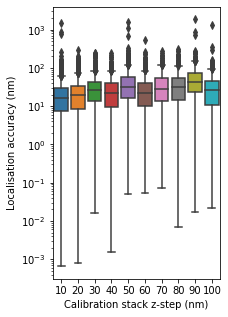

In [7]:
print(res.keys())
import seaborn as sns
import operator as op
keys, vals = zip(*res.items())
for k, v in res.items():
    print(k, np.mean(v), np.std(v))

sns.boxplot(data=vals)

# category labels
plt.xlabel('Calibration stack z-step (nm)')
plt.ylabel('Localisation accuracy (nm)')
plt.xticks(plt.xticks()[0], keys)
plt.yscale('log')


plt.show()

In [8]:
print(train_dataset.data['train'][1].min())
print(train_dataset.data['train'][1].max())

-999.998842049974
999.0107834299615


Explanation...
- More noise captured in higher-res data
- Higher res not 